In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact, FloatSlider, IntSlider, Button, Output 
display(HTML("<style>.rendered_html.text_cell_render {max-width:600px; }</style>")) 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Audio
from cgnai.utils import cgnai_home, listmap
from cgnai.fileio import ls, load
# import torch 
# from torch import nn
# from torch.nn import functional as F
# from torch.utils.data import DataLoader
# import torchaudio
# import librosa

In [ ]:
data_path = cgnai_home()/"shared/podverse/data/politik_podcast"

In [ ]:
files = [f for f in ls(data_path).files if f.endswith(".mp3")]
files[:10]

['der_politikpodcast_folge_251_runter_vom_russischen_gas_dlf_20220401_0137_4e4932d6.mp3',
 'der_politikpodcast_folge_252_impfpflicht_gescheitert_dlf_20220407_0137_03973028.mp3',
 'der_politikpodcast_folge_253_lage_der_linkspartei_dlf_20220421_0137_3246aef7.mp3',
 'der_politikpodcast_folge_255_twitter_und_politik_dlf_20220429_0137_0644b870.mp3',
 'der_politikpodcast_folge_256_zeitenwende_zwischen_berlin_und_dlf_20220506_0137_a6ddbb57.mp3',
 'der_politikpodcast_folge_257_finanzielle_entlastungen_mit_dlf_20220513_0137_8c31ac6b.mp3',
 'der_politikpodcast_folge_258_wo_steht_der_bund_nach_den_dlf_20220518_0137_dcf53b3c.mp3',
 'der_politikpodcast_folge_259_china_science_investigation_dlf_20220523_0137_56428023.mp3',
 'der_politikpodcast_folge_260_eu_gipfel_oelembargo_orban_dlf_20220531_0137_dac85854.mp3',
 'der_politikpodcast_folge_261_dlf_20220603_0137_e5b5c401.mp3']

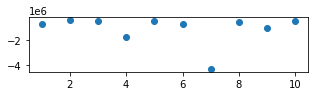

In [ ]:
def get_ids(fname, m):
    json = load(data_path/f"{fname}_diarization.json" )
    return json[m]["ids"]


def get_score(fname):
    json = load(data_path/f"{fname}_diarization.json" )
    ms = []
    sc = []
    for m in json.keys():
        ms.append(int(m))
        sc.append(json[m]["score"])
        
    return sorted(sc, key=lambda i: ms[sc.index(i)])

get_score(files[i_])
# -------------------
plt.figure(figsize=(5,1))
plt.scatter(ms,sc)


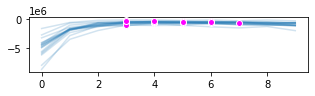

In [ ]:
plt.figure(figsize=(5,1))

for fname in files:
    sc  = get_score(fname)
    m   = np.argmax(sc)
    ids = get_ids(fname, str(m))
    pix = load(data_path/f"{fname}_pixels.npy" )
    seg = np.stack([pix[:-1],pix[1:]], axis=1)
    
    # -----------------
    plt.plot(sc, zorder=1, c="C0", alpha=0.2)
    plt.scatter(m, sc[m], zorder=10, c="magenta", edgecolor="w")

# Get Tracks

In [ ]:
def get_tracks(fname):
    sc  = get_score(fname)
    m   = np.argmax(sc)
    ids = get_ids(fname, str(m))
    
    pix = load(data_path/f"{fname}_pixels.npy" )
    segs = np.stack([pix[:-1],pix[1:]], axis=1)
    
    T = pix[-1]
    v = np.zeros(T)

    for i,s in zip(ids,segs):
        v[s[0]:s[1]] = i
        
    
    v = v.astype(int)
    D = (v[None,:] == v[:,None])*v[None]
    
    
    return v

In [ ]:
for fname in files[:5]:
    v = get_tracks(fname)

# Get Audio Wav

In [ ]:
import torchaudio
from pyannote.audio import Inference

torchaudio.set_audio_backend("sox_io")
inference = Inference("pyannote/embedding",
                      window="sliding",
                      duration=4.0, step=1.0)

In [ ]:
def get_embeddings(fname):

    wav, sr = torchaudio.load(data_path/fname, format="mp3")

    x = inference({'waveform': wav[[0],:], "sample_rate": sr}).data
    x = x/(np.linalg.norm(x, axis=1,keepdims=True)+10e-8)
    
    return x, (wav, sr)

# Clusters test

In [ ]:
i0 = 0
v = get_tracks(files[i0])
set(v), len(set(v))

({1, 2, 3, 4}, 4)

In [ ]:
x, (wav, sr) = get_embeddings(files[i0])

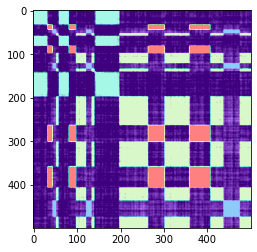

In [ ]:
D = x@x.T
SM = (v[None,:] == v[:,None])*v[None]
sub = 500
# ----------------
plt.figure(figsize=(4,4))
plt.imshow(D[:sub,:sub], cmap="binary_r", vmin=0.15, vmax=0.5)
plt.imshow(SM[:sub,:sub], alpha=0.5, cmap="rainbow")

In [ ]:
cl = {}
for i in set(v):
    cl[i] = (v == i)

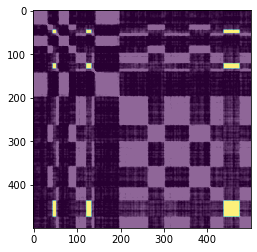

In [ ]:
D = x@x.T
i = 1
CL = cl[i][None,:] * cl[i][:,None]
sub = 500
# ----------------
plt.figure(figsize=(4,4))
plt.imshow(D[:sub,:sub], cmap="binary_r", vmin=0.15, vmax=0.5)
plt.imshow(CL[:sub,:sub], alpha=0.6, cmap="viridis")

# Get clusters

In [ ]:
def get_embedding(fname):
    x = load(data_path/f"{fname}_emb.npy" )
    return x

In [ ]:
def get_clusters(fname):
    v = get_tracks(fname)
    cl = {}
    for i in set(v):
        cl[i] = (v == i)
        
    return cl, v

In [ ]:
i = 1


cl,v = get_clusters(files[i])
x = get_embedding(files[i])

(1998, 512)


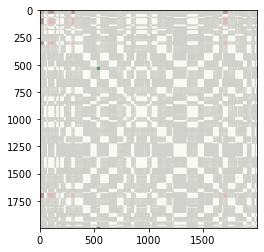

In [ ]:

print(x.shape)
D = x@x.T
a = 4
b = 6
CLa = cl[a][None,:] * cl[a][:,None]
CLb = cl[b][None,:] * cl[b][:,None]
t0 = 0
t1 = t0 + 2_000
# ----------------
plt.figure(figsize=(4,4))
plt.imshow(D  [t0:t1,t0:t1], cmap="binary_r", vmin=0.15, vmax=0.5)
plt.imshow(CLa[t0:t1,t0:t1], alpha=0.6, cmap="Reds")
plt.imshow(CLb[t0:t1,t0:t1], alpha=0.6, cmap="Greens")

In [ ]:
cl0.keys()

dict_keys([1, 2, 3, 4, 5, 6])

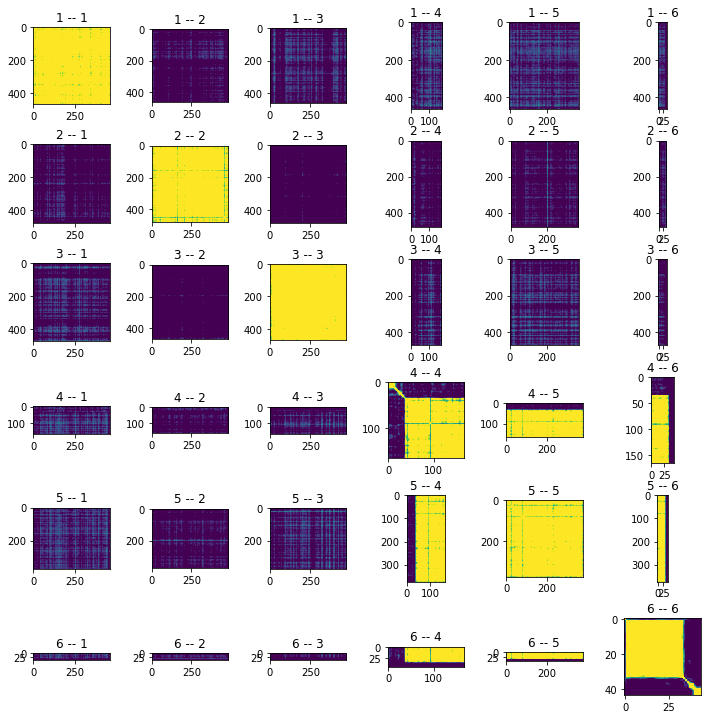

In [ ]:
T0 = len(x0)

num_tracks = len(cl0.keys())
csim = np.zeros((num_tracks, num_tracks))

fig, axs = plt.subplots(num_tracks, num_tracks, figsize=(10,10))
fig.tight_layout()
for ia,a in enumerate(cl0.keys()):
    for ib,b in enumerate(cl0.keys()):
#         if a >= b: continue
        axs[ia,ib].set_title(f"{a} -- {b}")
    
        M = x0[cl0[a]]@x0[cl0[b]].T
        axs[ia,ib].imshow(M, vmin=0.15, vmax=0.5)
        csim[ia,ib] = np.mean(M)

        

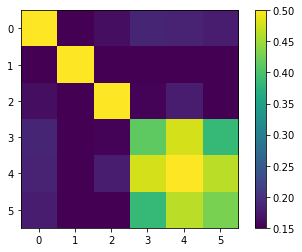

In [ ]:
plt.imshow(csim, vmax=0.5, vmin=0.15)
plt.colorbar()

# Cluster sims

In [ ]:
"""
    Compare two episodes
"""
i = 1
j = 2

fname_i = files[i]
fname_j = files[j]

def compare_two_episodes(fname_i, fname_j):
    cl_i,v_i = get_clusters(fname_i)
    x_i = get_embedding(fname_i)

    cl_j,v_j = get_clusters(fname_j)
    x_j = get_embedding(fname_j)

    T_i = len(x_i)
    T_j = len(x_j)

    n_i = len(cl_i.keys())
    n_j = len(cl_j.keys())

    csim = np.zeros((n_i, n_j))


#     fig, axs = plt.subplots(n_i, n_j, figsize=(10,10))
#     fig.tight_layout()
    for ia,a in enumerate(cl_i.keys()):
        for ib,b in enumerate(cl_j.keys()):

#             axs[ia,ib].set_title(f"{a} -- {b}")

            M = x_i[cl_i[a],:]@x_j[cl_j[b],:].T
#             axs[ia,ib].imshow(M, vmin=0.15, vmax=0.5)

            csim[ia,ib] = np.mean(M)
            
    return csim

In [ ]:
csims = []
for i in range(len(files)):
    csims.append([])
    for j in range(i, len(files)):
        print(f"{i} - {j} {len(files)}", end="\r")
        csim = compare_two_episodes(files[i], files[j])
        csims[-1].append(csim)
        

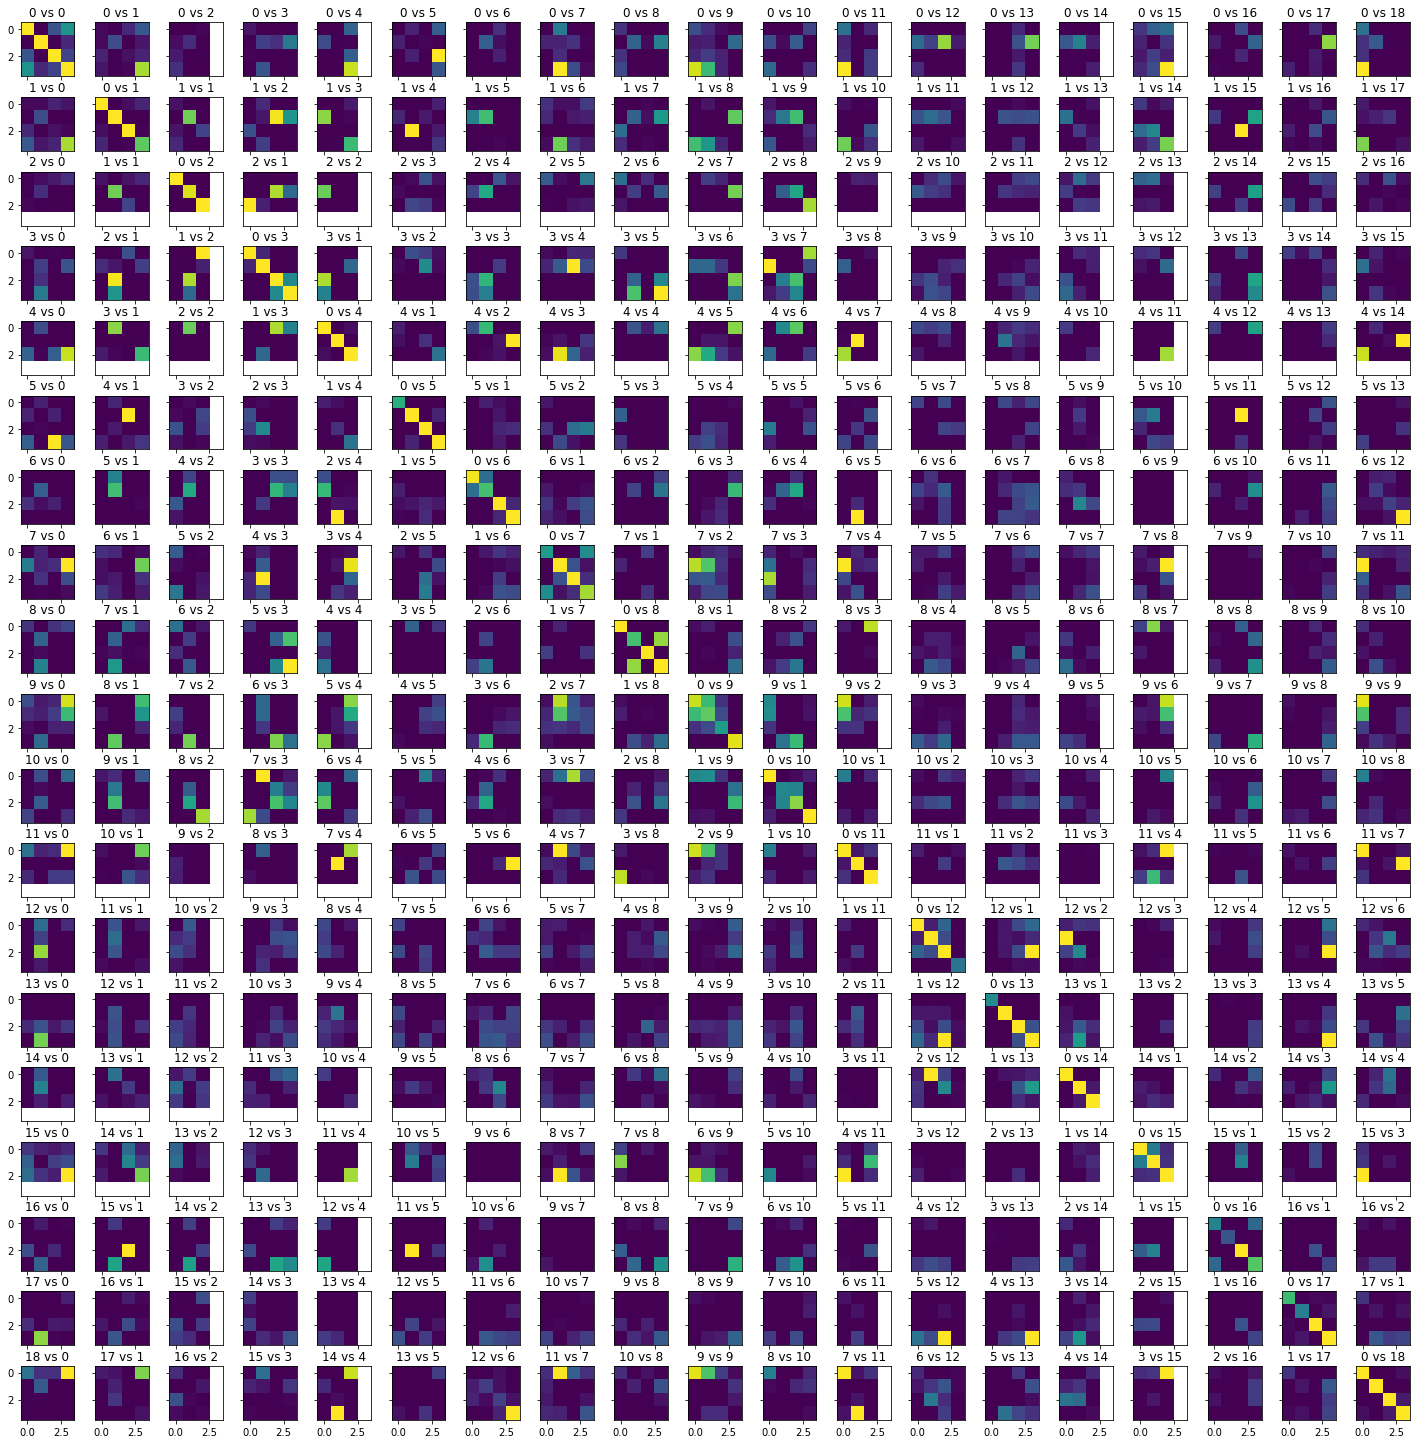

In [ ]:
n = len(csims)
fig, axs = plt.subplots(n,n, figsize=(20,20), sharex=True, sharey=True)
fig.tight_layout()
for i in range(n):
    for j in range(len(csims[i])):
        
        print(f"{i} - {j} {len(files)}", end="\r")
        
        cij = csims[i][j]
        
        axs[i,i+j].set_title(f"{i} vs {j}")
        axs[i,i+j].imshow(cij, vmin=0.15, vmax=0.5)
        
        axs[i+j, i].set_title(f"{j} vs {i}")
        axs[i+j,i].imshow(cij.T, vmin=0.15, vmax=0.5)
        
plt.savefig(f"_csim.jpg", bbox_inches='tight', dpi=150)

In [ ]:
cum = [0, *np.cumsum([c.shape[1] for c in csims[0]])]
super_sim = np.zeros((cum[-1],cum[-1]))

for i in range(n):
    for j_ in range(len(csims[i])):
        j = i + j_
        cij = csims[i][j_]

        super_sim[cum[i]:cum[i+1],cum[j]:cum[j+1] ] = cij
        super_sim[cum[j]:cum[j+1],cum[i]:cum[i+1] ] = cij.T
            

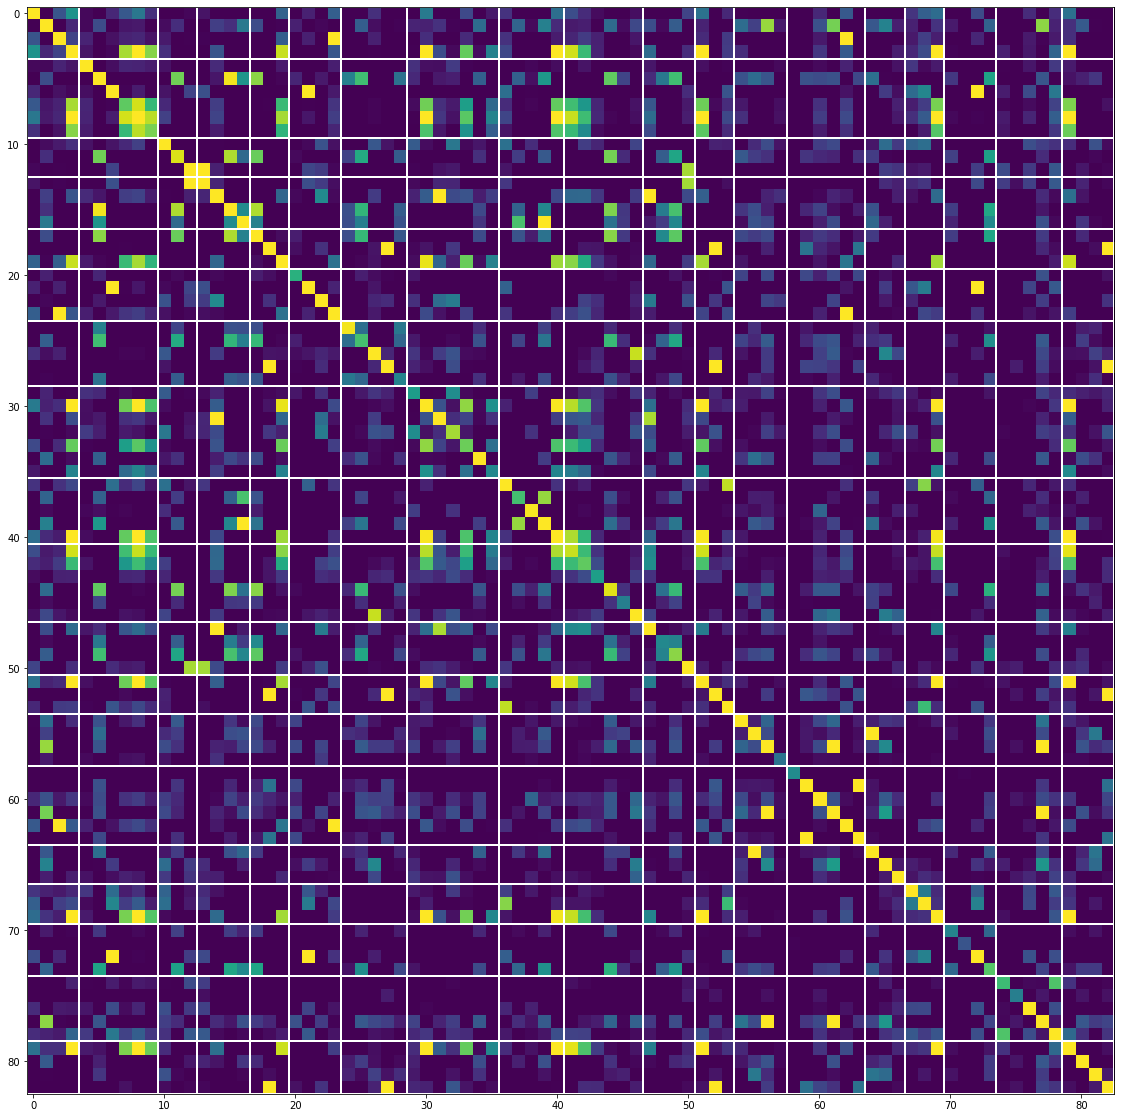

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(super_sim, vmin=0.15, vmax=0.5)
for c in cum:
    plt.hlines(c - 0.5,-0.5,cum[-1]-0.5, color="w", linewidth=2)
    plt.vlines(c - 0.5,-.5,cum[-1]-0.5, color="w", linewidth=2)
    
plt.savefig(f"_super_sim.jpg", bbox_inches='tight', dpi=150)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
from ipywidgets import interact, FloatSlider, IntSlider, Button, Output

pr = super_sim/np.sum(super_sim, axis=0, keepdims=True)
TT = len(pr)


@interact(
    i = IntSlider(min=0, max=TT-1, step=1, value=10, description='i:')
)

def func(i):
    v = np.zeros(TT)
    v[i] = 1

    plt.figure(figsize=(20,2))
#     plt.plot(v)
    w = pr@v
    plt.plot(w)
    w = pr@w
    plt.plot(w)
    w = pr@w
    plt.plot(w)
    print(w.shape)
#     plt.figure(figsize=(20,20))
#     plt.imshow(w[:,None]@w[None,:])



interactive(children=(IntSlider(value=10, description='i:', max=82), Output()), _dom_classes=('widget-interact…

In [ ]:
# fname =>_set(names)